In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
cd 'drive/My Drive/Colab Notebooks/oleg/Prac6'

[Errno 2] No such file or directory: 'drive/My Drive/Colab Notebooks/oleg/Prac6'
/content/drive/My Drive/Colab Notebooks/oleg/Prac6


In [0]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch as t
from torch.utils import data
import torch.nn.functional as F
from torchvision import transforms as tsf
import scipy.misc
import torch.nn as nn
from pathlib import Path


from PIL import Image
import skimage
from skimage import io

from torch.utils.tensorboard import SummaryWriter

from collections import defaultdict
from random import randint
import copy

TRAIN_PATH = './train.pth'
TEST_PATH = './test.tph'
%matplotlib inline

In [0]:
def process(dataset_path, mask_path,target_path=None):
    data=defaultdict(dict)
    l=[(dataset_path,'img'),(mask_path,'mask'),(target_path,'target')]
    for p,n in l:
        if p is None:
            continue
        for image in Path(p).iterdir():
            name=image.name.split('_')[0]
            img=Image.open(image)
            data[name][n]=img
    return data

train_data = [*process('train/images','train/mask/',"train/1st_manual/").values()]

In [0]:
l=[]
for d in train_data:
    img=d['img']
    img=tsf.Compose([
        tsf.Resize((512,512)),
        tsf.ToTensor()
        ]) (img)

    l.append(img)

tmp=t.cat([a[None] for a in l],dim=0)
means=[a.item() for a in tmp.mean(dim=[0,2,3])]
stds=[a.item() for a in tmp.std(dim=[0,2,3])]

In [0]:
def flip_transform(img,mask,target,r=None):
    if r is None:
        r=randint(0,3)

    if r==0:
        flip=[]
    elif r==1:
        flip=[0]
    elif r==2:
        flip=[1]
    else:
        flip=[0,1]
        
    
    img[0]=t.flip(img[0],dims=flip)
    img[1]=t.flip(img[1],dims=flip)
    img[2]=t.flip(img[2],dims=flip)

    mask[0]=t.flip(mask[0],dims=flip)
    target[0]=t.flip(target[0],dims=flip)

In [0]:
import PIL
class Dataset():
    def __init__(self,data,source_transform,target_transform):
        self.datas = data
        self.s_transform = source_transform
        self.t_transform = target_transform
    def __getitem__(self, index):
        true_index=index//4
        transform_index=index%4

        data = self.datas[true_index]
        img = data['img']
        mask = data['mask']
        target=data['target']



        img = self.s_transform(img)
        mask = self.t_transform(mask)
        target=self.t_transform(target)

        flip_transform(img,mask,target,transform_index)
        return img, mask,target
    def __len__(self):
        return len(self.datas)*4

s_trans = tsf.Compose([
    tsf.Resize((512,512)),
    tsf.ToTensor(),
    tsf.Normalize(mean = means,
                  std = stds)
]
)
t_trans = tsf.Compose([
    tsf.Resize((512,512),interpolation=PIL.Image.NEAREST),
    tsf.ToTensor()]
)
dataset = Dataset(train_data[:-2],s_trans,t_trans)
test_dataset=Dataset(train_data[-2:],s_trans,t_trans)
dataloader = t.utils.data.DataLoader(dataset,num_workers=2,batch_size=2,shuffle=True)

In [0]:
def show(old_img,mask,target):
    plt.subplot(131)
    img=t.tensor(old_img)
    for i in range(3):
        img[i]*=stds[i]
        img[i]+=means[i]
    plt.imshow(img.permute(1,2,0).numpy())
    plt.subplot(132)
    plt.imshow(mask[0].numpy())
    plt.subplot(133)
    plt.imshow(target[0].numpy())
    plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


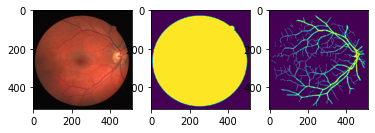

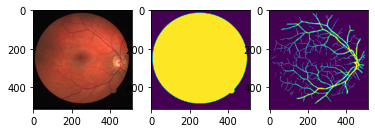

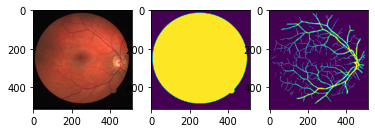

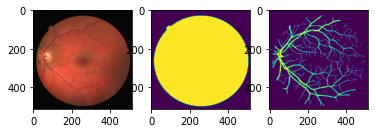

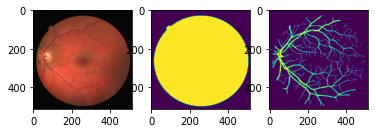

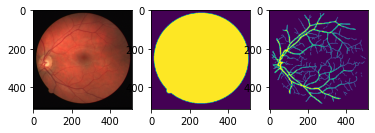

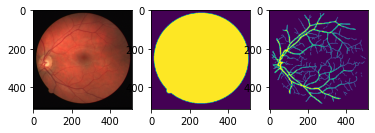

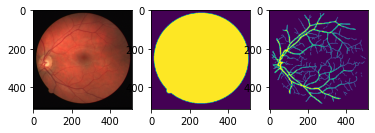

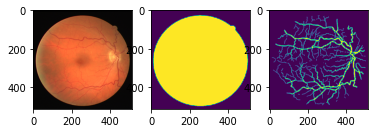

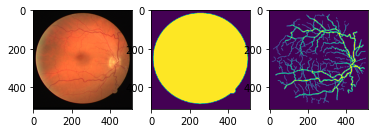

In [29]:
for i in range(5):
    img,mask,target = dataset[i]
    show(img,mask,target)
    flip_transform(img,mask,target)
    show(img,mask,target)

In [0]:
class double_conv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2)
        )

    def forward(self, x):
        x = self.conv(x)
        return x

class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            double_conv(in_ch,out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x

class up(nn.Module):
    def __init__(self, in_ch):
        super(up, self).__init__()
        self.up = nn.ConvTranspose2d(in_ch, in_ch//2, 2, stride=2)
        #self.bn=nn.BatchNorm2d(in_ch//2)

    def forward(self, x):
        x=self.up(x)
        #x=self.bn(x)
        #x=nn.ReLU()(x)
        return x

class UNet(nn.Module):
    def __init__(self, n_channels):
        super(UNet, self).__init__()

        self.dc0=double_conv(3,64)

        self.down1=down(64,128)
        self.down2=down(128,256)
        self.down3=down(256,512)
        self.down4=down(512,1024)

        self.up1 = up(1024)
        self.up2 = up(512)
        self.up3 = up(256)
        self.up4 = up(128)

        self.dc1=double_conv(1024,512)
        self.dc2=double_conv(512,256)
        self.dc3=double_conv(256,128)
        self.dc4=double_conv(128,64)
  
        self.outc = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        x0=self.dc0(x)
        x1=self.down1(x0)
        x2=self.down2(x1)
        x3=self.down3(x2)
        x4=self.down4(x3)


        x=self.up1(x4)
        x=t.cat([x,x3],dim=1)
        x=self.dc1(x)

        x=self.up2(x)
        x=t.cat([x,x2],dim=1)
        x=self.dc2(x)

        x=self.up3(x)
        x=t.cat([x,x1],dim=1)
        x=self.dc3(x)

        x=self.up4(x)
        x=t.cat([x,x0],dim=1)
        x=self.dc4(x)

        x=self.outc(x)
        x=t.sigmoid(x)
        return x

In [0]:
def dice_f(y_pred,y,target):
    target=target.view(-1)
    mask=target==1
    
    tp=(y_pred*y)[mask].sum().float()
    fp=y_pred[mask].sum()-tp
    fn=y[mask].sum()-tp
    return 2*tp/(2*tp+fp+fn)

In [0]:
dataset = Dataset(train_data[:-2],s_trans,t_trans)
test_dataset=Dataset(train_data[-2:],s_trans,t_trans)
all_dataset=Dataset(train_data,s_trans,t_trans)
dataloader = t.utils.data.DataLoader(dataset,num_workers=2,batch_size=2,shuffle=True)

In [0]:
model=UNet(3)
model=model.cuda()
model=model.train()

losses=[]
dices=[]
best_loss=9999999999
num_ep=100
optimizer = t.optim.Adam(model.parameters(), lr=0.001)
nl=nn.BCELoss(reduction='none')
for n in range(num_ep):
    for img,mask,target in dataloader:
        optimizer.zero_grad()     
        mask=mask.to('cuda')
        img=img.to('cuda')
        target=target.to('cuda')
        y_pred=model(img)

        y_pred=y_pred.permute(0,2,3,1).reshape(-1)
        y=target.permute(0,2,3,1).view(-1).float()
        mask=mask.permute(0,2,3,1).view(-1).long()

        loss=nl(y_pred,y)
        loss=loss[mask==1]

        loss=loss.mean()
        loss.backward()
        optimizer.step()

    with t.no_grad():
        model=model.eval()
        loss=0.
        dice=0.
        for img,mask,target in test_dataset:
            mask=mask[None].to('cuda')
            img=img[None].to('cuda')
            target=target[None].to('cuda')
            y_pred=model(img)

            y_pred=y_pred.permute(0,2,3,1).reshape(-1)
            y=target.permute(0,2,3,1).view(-1).float()
            mask=mask.permute(0,2,3,1).view(-1).long()

            tmp=nl(y_pred,y)
            tmp=tmp[mask==1]

            loss+=tmp.mean()
            dice+=dice_f(y_pred,y,mask).cpu().item()

        loss/=len(test_dataset)
        dice/=len(test_dataset)
        losses.append(loss.cpu().item())
        dices.append(dice)
        model=model.train()

        if loss<best_loss:
            best_loss=loss
            best_model = copy.deepcopy(model)
    print(n)

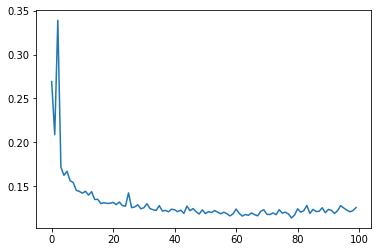

In [146]:
plt.plot(list(range(len(losses))),losses)

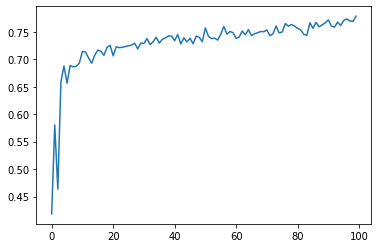

In [147]:
plt.plot(list(range(len(losses))),dices)

***Это лишь псевдо dice, так-как treshold пока не известен***

In [0]:
dices[-10:]

In [0]:
best_model=best_model.eval()

In [0]:
best_s=0
i=0
for th in [0.1,0.2,0.3,0.4,0.5,0.6,0.7]:
    s=0
    for ind, (img,mask,target) in enumerate(all_dataset):
        if ind%4:
            continue
        mask=mask[None]
        target=target[None]
        img=img[None]
        pred_target=(best_model(img.to('cuda'))>th).int().cpu()
        pred_target=pred_target.permute(0,2,3,1).reshape(-1)
        y=target.permute(0,2,3,1).view(-1).float()
        mask=mask.permute(0,2,3,1).view(-1).long()
        s+=dice_f(pred_target,y,mask).cpu().item()
    s/=len(all_dataset)
    s*=4
    i+=1
    print(i)
    if best_s<s:
        best_s=s
        best_th=th
print(best_s)
print(best_th)

In [0]:
best_s=0
i=0
for th in [best_th+i/10-1 for i in range(21)]:
    s=0
    for ind, (img,mask,target) in enumerate(all_dataset):
        if ind%4:
            continue
        mask=mask[None]
        target=target[None]
        img=img[None]
        pred_target=(best_model(img.to('cuda'))>th).int().cpu()
        pred_target=pred_target.permute(0,2,3,1).reshape(-1)
        y=target.permute(0,2,3,1).view(-1).float()
        mask=mask.permute(0,2,3,1).view(-1).long()
        s+=dice_f(pred_target,y,mask).cpu().item()
    s/=len(all_dataset)
    s*=4
    i+=1
    print(i)
    if best_s<s:
        best_s=s
        best_th=th
print(best_s)
print(best_th)

In [0]:
class TestDataset():
    def __init__(self,data,source_transform):
        self.datas = [*data.items()]
        self.s_transform = source_transform
    def __getitem__(self, index):
        name,data = self.datas[index]
        img = data['img']
        img = self.s_transform(img)
        return name,img
    def __len__(self):
        return len(self.datas)


testdata=process('test/images/','test/mask/')
testset = TestDataset(testdata, s_trans)
testdataloader = t.utils.data.DataLoader(testset,batch_size=1)

In [0]:
import skimage.transform
import imageio

In [0]:
os.makedirs("results")

In [0]:
def check(model,th,dataset):
    s=0
    for ind, (img,mask,target) in enumerate(dataset):
        if ind%4:
            continue
        mask=mask[None]
        target=target[None]
        img=img[None]
        pred_target=(model(img.to('cuda'))>th).int().cpu()
        pred_target=pred_target.permute(0,2,3,1).reshape(-1)
        y=target.permute(0,2,3,1).view(-1).float()
        mask=mask.permute(0,2,3,1).view(-1).long()
        s+=dice_f(pred_target,y,mask).cpu().item()
    s/=len(dataset)
    s*=4
    return s

In [0]:
model=model.eval()
best_model=best_model.eval()

In [131]:
check(best_model,best_th,test_dataset)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


0.8329886794090271

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


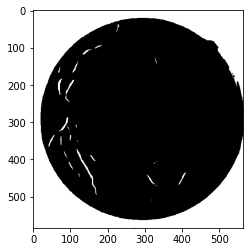

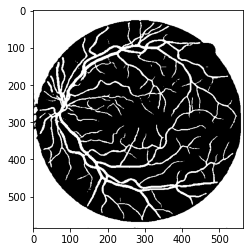

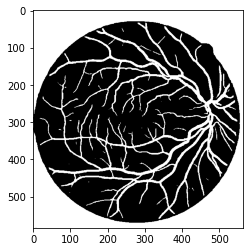

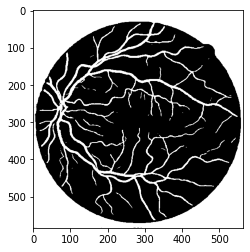

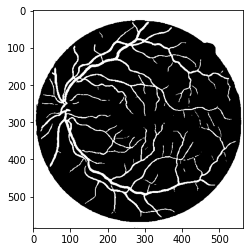

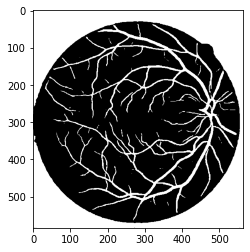

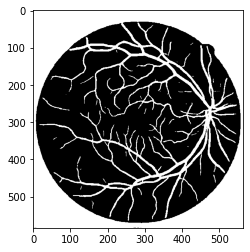

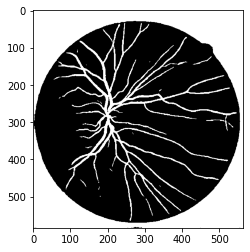

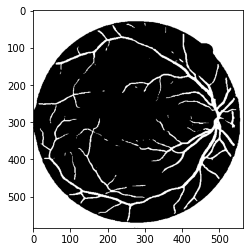

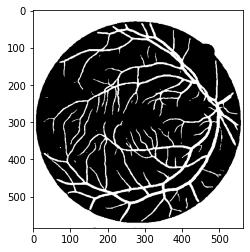

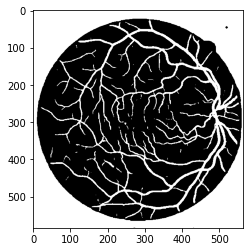

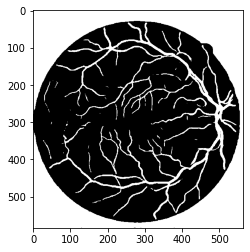

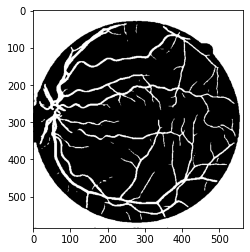

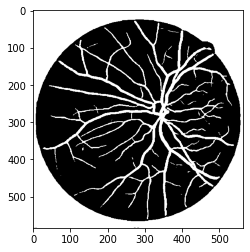

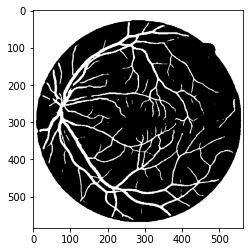

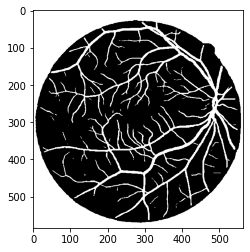

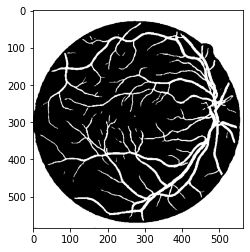

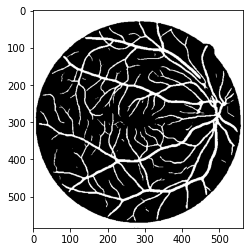

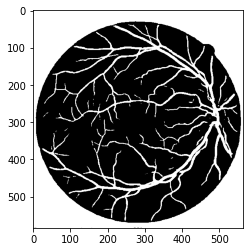

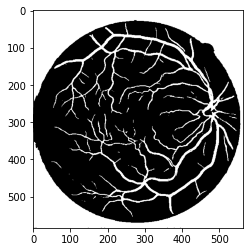

In [163]:
best_model = best_model.eval()
for name, data in testdataloader:
    data = t.autograd.Variable(data, volatile=True).cuda()
    name=name[0]

    img=(best_model(data)[0]>best_th).int().cpu()

    source_image = Image.open("test/images/%s_test.tif" % name)

    img=tsf.ToPILImage()(img.float())
    img=tsf.Resize(source_image.size[::-1])(img)
    img = tsf.ToTensor()(img)[0].numpy()
    img=(img>0.5).astype(int)

    plt.imshow(img,cmap=plt.cm.Greys_r)
    plt.show()
    
    imageio.imwrite("results/%s.png" % name, img)